This notebook is used to postprocessing the inverse modeling results of the cloud chamber model.

In [11]:
# Libraries
from pathlib import Path
import pandas as pd
import numpy as np

from kim.map import KIM
from kim.data import Data
from kim.mapping_model import MLP

import jax


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# define the colors
cmap = mpl.colors.ListedColormap(['white', 'k'])

# create a normalize object the describes the limits of
# each color
bounds = [-.5, 0.5, 1.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


In [3]:
jax.devices()

[CpuDevice(id=0)]

# Read the data

In [4]:
# File and folder paths
f_para = Path("./data/Output.csv")
f_state = Path("./data/Input.csv")


In [5]:
df_para, df_state = pd.read_csv(f_para),pd.read_csv(f_state)

In [6]:
y_keys, x_keys = df_para.keys(), df_state.keys()
y, x = df_para.values, df_state.values

In [7]:
x.shape, y.shape

((33, 1296), (33, 2))

# Load the preliminary analysis results

In [9]:
f_data_save = Path("./results/data")
data = Data(x, y)
data.load(f_data_save)


In [39]:
data.sensitivity_mask.shape

(1296, 2)

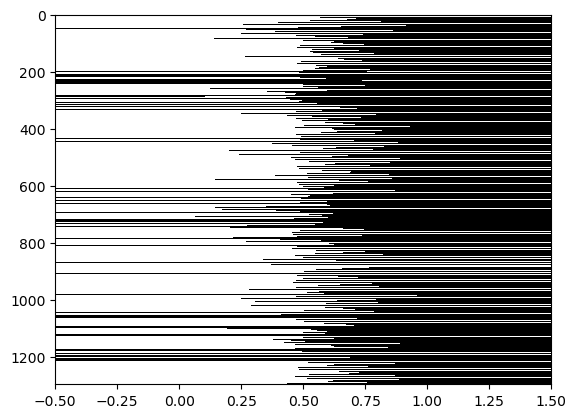

In [33]:
plt.imshow(data.sensitivity_mask, aspect='auto', cmap=cmap, norm=norm)

In [34]:
data.cond_sensitivity_mask

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])

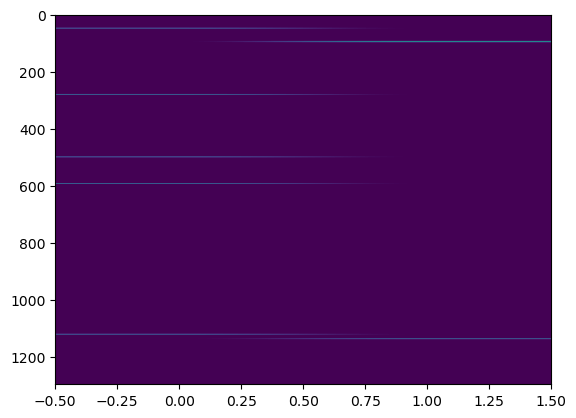

In [40]:
plt.imshow(data.cond_sensitivity_mask, aspect='auto')

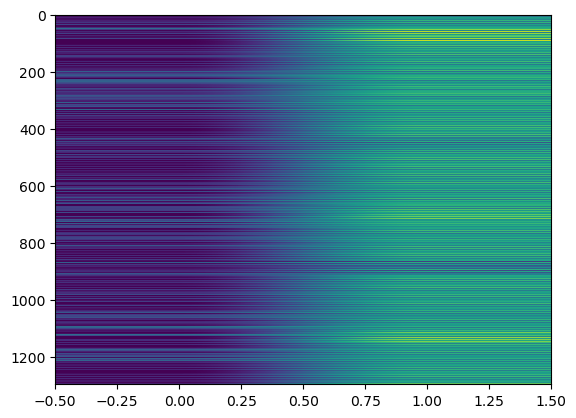

In [38]:
plt.imshow(data.sensitivity, aspect='auto')

# Configurations

In [19]:
Ns_train = 30000
hidden_activation = 'sigmoid'
final_activation = 'leaky_relu'
seed = 1024
seed_predict = 3636
seed_dl = 10
seed_model = 100
seed_shuffle = 1234
training_verbose = 1

n_models = 100

f_data_save = Path("./results/data")
f_kim_save = Path("./results")


In [21]:
# Data configuration
data_params = {
    "xscaler_type": "standard",
    "yscaler_type": "standard",
    # "xscaler_type": "",
    # "yscaler_type": "",
}

# Sensitivity analysis configuration
sensitivity_params = {
    "method": "pc", "metric": "corr",
    "sst": True, "ntest": 100, "alpha": 0.05, "k": 3,
    "n_jobs": 100, "seed_shuffle": seed_shuffle,
    "verbose": 1
}

# Mapping parameters for each test below
map_configs = {
    "model_type": MLP,
    'n_model': n_models,
    'ensemble_type': 'ens_random',
    'model_hp_choices': {
        "depth": [1,3,5,6],
        "width_size": [3,6,10]
        # "depth": [6],
        # "width_size": [6]
    },
    'model_hp_fixed': {
        "hidden_activation": hidden_activation,
        "final_activation": final_activation,
        "model_seed": seed_model
    },
    'optax_hp_choices': {
        'learning_rate': [0.01, 0.005, 0.003],
    },
    'optax_hp_fixed': {
        'nsteps': 300,
        'optimizer_type': 'adam',
    },
    'dl_hp_choices': {
    },
    'dl_hp_fixed': {
        'dl_seed': seed_dl,
        'num_train_sample': Ns_train,
        'batch_size': 64
    },
    'ens_seed': seed,
    'training_parallel': True,
    'parallel_config': {
        'n_jobs': n_models, 
        'backend': 'loky',
        'verbose': 1
    },
    'device': None,
}

# Exploratory data analysis

In [16]:
data = Data(x, y, **data_params)
data.calculate_sensitivity(**sensitivity_params)


/Users/jian449/anaconda3/envs/kim/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [17]:
data.sensitivity_mask

array([[False, False],
       [False, False],
       [False,  True],
       ...,
       [ True,  True],
       [False,  True],
       [False,  True]])

In [18]:
data.cond_sensitivity_mask

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])

In [22]:
# Save the sensitivity analysis to disk
data.save(f_data_save)

# Train the inverse mapping

In [12]:
d = jax.numpy.array([0,3,5,7])
d.devices()

{CpuDevice(id=0)}

In [ ]:
# Initialize three diffferent KIMs
kim1 = KIM(data, map_configs, map_option='many2many')
kim2 = KIM(data, map_configs, mask_option="sensitivity", map_option='many2one')
kim3 = KIM(data, map_configs, mask_option="cond_sensitivity", map_option='many2one')

# Train the mappings
kim1.train()
kim2.train()
kim3.train()



 Performing ensemble training in parallel with 100 model configurations...



[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on t